In [7]:
import pandas as pd

# Rutas de los archivos
sales_file_path = './sales_test.csv'
products_file_path = './products.csv'
stock_file_path = './initial_stock.csv'

# Cargar los datasets
sales = pd.read_csv(sales_file_path)
products = pd.read_csv(products_file_path)
stock = pd.read_csv(stock_file_path)

## Classic Methods MENSUAL RESTOCK


In [47]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [49]:
# Renombrar la columna 'id' a 'product_id' en products
products.rename(columns={'id': 'product_id'}, inplace=True)

# Combinar los datos
data = pd.merge(sales, products, on='product_id', how='left')
data = pd.merge(data, stock, on='product_id', how='left')

# Convertir la columna 'date' a datetime si no lo es
data['date'] = pd.to_datetime(data['date'])

# Crear características adicionales
data['Days to Expire'] = (pd.to_datetime(data['batch_expiry_date']) - data['date']).dt.days
data['Total Revenue'] = data['total_price']
data['Price_USD'] = data['Price_USD']
data['Remaining stock'] = data['remaining_stock']

data["month"] = data["date"].dt.month
data["year"] = data["date"].dt.year


monthly_data = data.groupby(["month", "year", "product_id"]).agg(
    total_revenue=('Total Revenue', 'sum'),
    average_price=('Price_USD', 'mean'),
    stock=('remaining_stock', 'last'),
    average_days_to_expire=('Days to Expire', 'mean'),
    quantity = ('quantity_x', 'sum')
).reset_index()


# Seleccionar las características y el target para el modelo mensual
features_monthly = monthly_data[['total_revenue', 'average_price', 'stock']]
target_monthly = monthly_data['quantity']

# Dividir los datos mensuales en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    features_monthly, target_monthly, test_size=0.2, random_state=42
)
# Escalar las características
scaler_monthly = StandardScaler()
X_train_scaled = scaler_monthly.fit_transform(X_train)
X_test_scaled = scaler_monthly.transform(X_test)

X_train_scaled = np.array(X_train_scaled)
X_test_scaled = np.array(X_test_scaled)
y_train = np.array(y_train).flatten()  
y_test = np.array(y_test).flatten()

In [18]:
# Evaluar múltiples modelos
results = {}

# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
results['Random Forest'] = {
    'MSE': mean_squared_error(y_test, y_pred_rf),
    'R2': r2_score(y_test, y_pred_rf)
}

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
y_pred_linear = linear_model.predict(X_test_scaled)
results['Linear Regression'] = {
    'MSE': mean_squared_error(y_test, y_pred_linear),
    'R2': r2_score(y_test, y_pred_linear)
}

# Polynomial Regression
degrees = range(1, 6)  # Testing degrees from 1 to 5
poly_results = {}

for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)
    y_pred_poly = poly_model.predict(X_test_poly)

    poly_results[degree] = {
        'MSE': mean_squared_error(y_test, y_pred_poly),
        'R2': r2_score(y_test, y_pred_poly)
    }

# Find the best degree and add to results
best_degree = max(poly_results, key=lambda d: poly_results[d]['R2'])
results['Polynomial Regression (Best Degree)'] = {
    'Degree': best_degree,
    'MSE': poly_results[best_degree]['MSE'],
    'R2': poly_results[best_degree]['R2']
}

# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_test_scaled)
results['Gradient Boosting'] = {
    'MSE': mean_squared_error(y_test, y_pred_gb),
    'R2': r2_score(y_test, y_pred_gb)
}

# K-Nearest Neighbors Regressor
knn_model = KNeighborsRegressor()
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)
results['KNN Regressor'] = {
    'MSE': mean_squared_error(y_test, y_pred_knn),
    'R2': r2_score(y_test, y_pred_knn)
}

# Support Vector Regressor
svr_model = SVR()
svr_model.fit(X_train_scaled, y_train)
y_pred_svr = svr_model.predict(X_test_scaled)
results['Support Vector Regressor'] = {
    'MSE': mean_squared_error(y_test, y_pred_svr),
    'R2': r2_score(y_test, y_pred_svr)
}

# Neural Network
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')
])

nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
nn_model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=50, batch_size=32, verbose=0)
nn_loss, nn_mae = nn_model.evaluate(X_test_scaled, y_test, verbose=0)
y_pred_nn = nn_model.predict(X_test_scaled).flatten()
results['Neural Network'] = {
    'MSE': mean_squared_error(y_test, y_pred_nn),
    'R2': r2_score(y_test, y_pred_nn),
    'MAE': nn_mae
}

# Output results
print('Model Performance Summary:')
for model, metrics in results.items():
    if 'Degree' in metrics:
        print(f"{model} (Degree {metrics['Degree']}): MSE={metrics['MSE']}, R2={metrics['R2']}")
    else:
        print(f"{model}: MSE={metrics['MSE']}, R2={metrics['R2']}")


/home/luiso/Desktop/code/reboot-academy/Proyecto_Final/AI_discount_recommendation_based_on_expiration_date/env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/luiso/Desktop/code/reboot-academy/Proyecto_Final/AI_discount_recommendation_based_on_expiration_date/env/lib/python3.11/site-packages/numpy/_core/_dtype.py:106: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if dtype.type == np.bool:


ValueError: Value returned by __array__ is not a NumPy array

## Prophet Mensual


   sale_id  product_id       date  quantity  total_price batch_expiry_date  \
0        1           1 2020-01-01         1       149.16        2025-02-28   
1        2          14 2020-01-01         1        11.44        2025-03-05   
2        3           6 2020-01-01         1       102.88        2025-02-17   
3        4          22 2020-01-01         1        31.52        2025-07-04   
4        5          10 2020-01-01         1       136.35        2025-04-15   

   remaining_stock  warehouse_occupancy_rate  weekday  days_to_expiry  
0               30                      85.4        2            1885  
1                6                      85.2        2            1890  
2               21                      85.0        2            1874  
3                3                      84.8        2            2011  
4                9                      84.6        2            1931  
          ds  y
0 2020-01-01  1
1 2020-01-01  1
2 2020-01-01  1
3 2020-01-01  1
4 2020-01-01  1


/home/rebooter/code/Final_Proyect/script_datos_sintéticos_ira/AI_discount_recommendation_based_on_expiration_date/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
16:21:43 - cmdstanpy - INFO - Chain [1] start processing
16:21:43 - cmdstanpy - INFO - Chain [1] done processing


             ds      yhat  yhat_lower  yhat_upper
1850 2025-01-24  1.119890    0.726997    1.502344
1851 2025-01-25  1.121210    0.750689    1.492200
1852 2025-01-26  1.122264    0.766923    1.520541
1853 2025-01-27  1.123022    0.766197    1.504028
1854 2025-01-28  1.123463    0.733253    1.488458


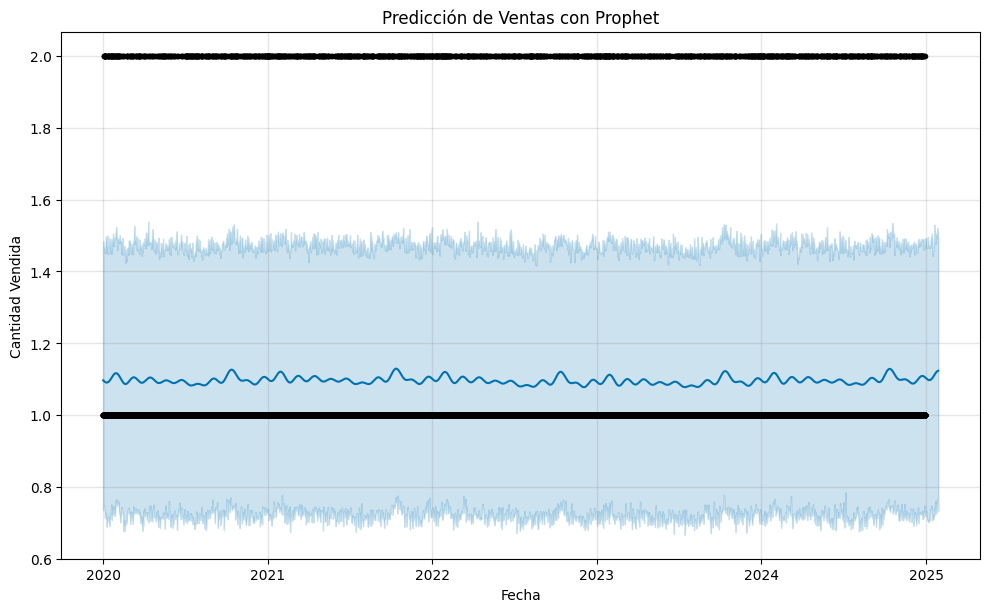

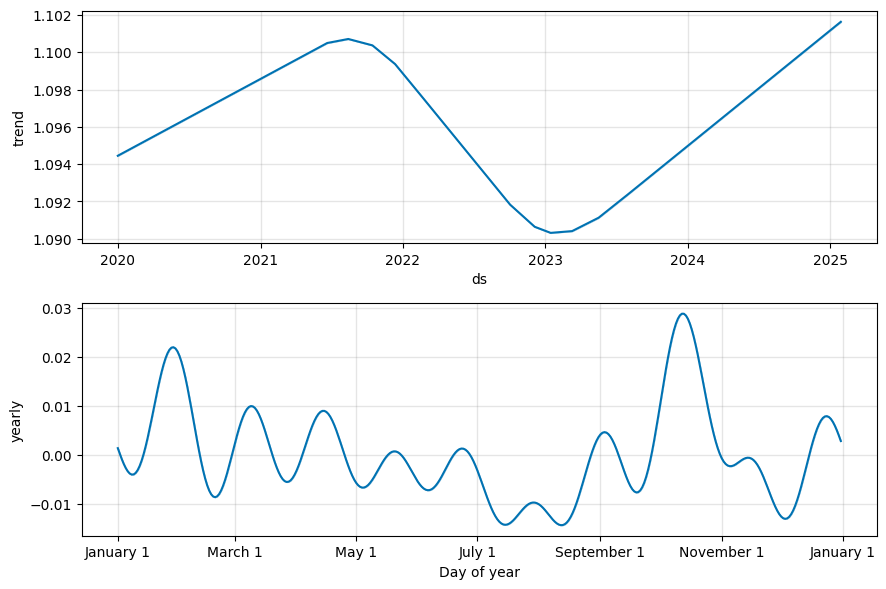

Evaluación del Modelo:
Mean Squared Error (MSE): 0.06504130828088406
R-Squared (R²): -0.04530674022849368


In [16]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# === Paso 1: Cargar Datos ===
# Revisar las columnas y asegurarnos de que tienen el formato correcto
print(sales.head())

# === Paso 2: Preparar Datos ===
# Prophet requiere columnas específicas: 'ds' (fecha) y 'y' (variable objetivo)
# Asumimos que 'date' contiene las fechas y 'quantity' las ventas
df = sales[['date', 'quantity']].rename(columns={'date': 'ds', 'quantity': 'y'})
df['ds'] = pd.to_datetime(df['ds'])  # Asegurarnos de que las fechas estén en formato datetime

# Verificar que los datos estén listos
print(df.head())

# === Paso 3: Dividir los Datos (Entrenamiento y Prueba) ===
# Usaremos los últimos 30 días como prueba, el resto para entrenamiento
train = df.iloc[:-30]  # Datos históricos menos los últimos 30 días
test = df.iloc[-30:]   # Los últimos 30 días

# === Paso 4: Crear y Entrenar el Modelo Prophet ===
# Crear una nueva instancia de Prophet para el modelo
model = Prophet(weekly_seasonality=False)

# Ajustar el modelo a los datos de entrenamiento
model.fit(train)

# === Paso 5: Generar Predicciones ===
# Crear un DataFrame para predicciones futuras (30 días adicionales)
future = model.make_future_dataframe(periods=30)  # Generar las fechas futuras
forecast = model.predict(future)  # Predecir

# Mostrar las predicciones generadas
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# === Paso 6: Visualizar Resultados ===
# Gráfico de predicciones
model.plot(forecast)
plt.title('Predicción de Ventas con Prophet')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Vendida')
plt.show()

# Gráfico de componentes (tendencia y estacionalidad)
model.plot_components(forecast)
plt.show()

# === Paso 7: Evaluar el Modelo ===
# Extraer predicciones correspondientes a las fechas de prueba
test_forecast = forecast[-30:]  # Últimos 30 días predichos
y_true = test['y'].values       # Valores reales
y_pred = test_forecast['yhat'].values  # Predicciones de Prophet

# Calcular métricas de evaluación
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Evaluación del Modelo:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-Squared (R²): {r2}")


### SARIMA (mensual)

/home/rebooter/code/Final_Proyect/script_datos_sintéticos_ira/AI_discount_recommendation_based_on_expiration_date/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/rebooter/code/Final_Proyect/script_datos_sintéticos_ira/AI_discount_recommendation_based_on_expiration_date/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Mean Squared Error (MSE): 63.73713409827198
R-Squared (R²): 0.986871556577918


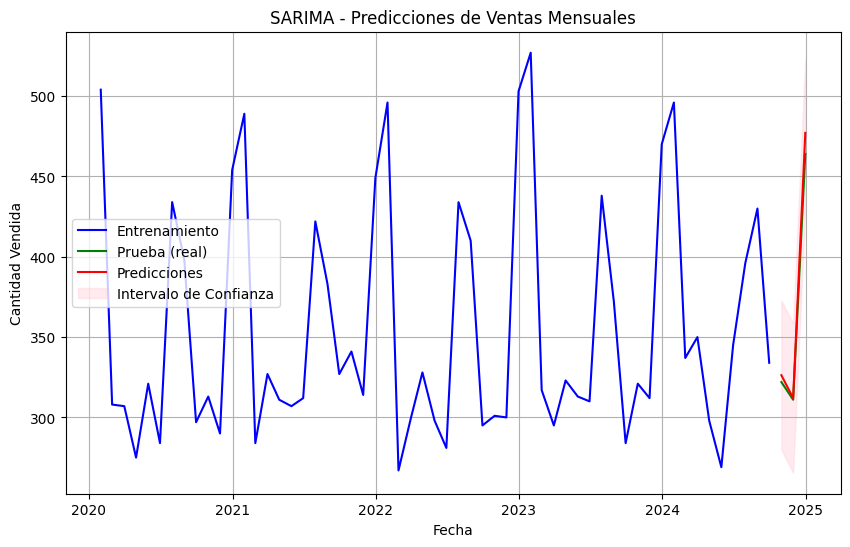

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# === Paso 1: Preparar los Datos ===
# Cargar los datos
sales_data = pd.read_csv('sales_test.csv')

# Convertir la columna 'date' a formato datetime
sales_data['date'] = pd.to_datetime(sales_data['date'])

# Agrupar los datos por mes y sumar las ventas
monthly_sales = sales_data.groupby(pd.Grouper(key='date', freq='M')).sum()['quantity']

# === Paso 2: Dividir los Datos ===
# Usar los últimos 3 meses para prueba
train = monthly_sales[:-3]
test = monthly_sales[-3:]

# === Paso 3: Ajustar el Modelo SARIMA ===
# Ajustar el modelo (configuración inicial SARIMA(1, 1, 1)(1, 1, 1, 12))
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = model.fit(disp=False)

# === Paso 4: Realizar Predicciones ===
# Predicciones para el período de prueba
pred = sarima_fit.get_forecast(steps=len(test))
pred_ci = pred.conf_int()

# === Paso 5: Evaluar el Modelo ===
# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(test, pred.predicted_mean)
print(f"Mean Squared Error (MSE): {mse}")
r2 = r2_score(test, pred.predicted_mean)
print(f"R-Squared (R²): {r2}")


# === Paso 6: Visualizar Resultados ===
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Entrenamiento', color='blue')
plt.plot(test.index, test, label='Prueba (real)', color='green')
plt.plot(test.index, pred.predicted_mean, label='Predicciones', color='red')
plt.fill_between(test.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='pink', alpha=0.3, label='Intervalo de Confianza')
plt.title('SARIMA - Predicciones de Ventas Mensuales')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Vendida')
plt.legend()
plt.grid()
plt.show()
